In [41]:
%matplotlib inline
import networkx as nx
import metis
import random
import string
from tqdm import tqdm
from itertools import chain
from matplotlib import pyplot as plt
from collections import Counter, defaultdict
import pandas as pd

In [42]:
GAMMA = 1.5

In [43]:
def get_alpha(g, k=2, gamma=GAMMA):
    return np.sqrt(k) * g.number_of_edges() / np.power(g.number_of_nodes(), GAMMA)

In [44]:
def attempt_reassignment(g, n, partition, node2cluster, gamma, alpha):    
    c_star = best_cluster_id(g, n, partition, gamma, alpha)
    did_it = False
    node_exist = (n in node2cluster)
    if node_exist:
        if node2cluster[n] != c_star:
            partition[node2cluster[n]].remove(n)
            partition[c_star].add(n)
            node2cluster[n] = c_star
            did_it = True
    else:
        partition[c_star].add(n)
        node2cluster[n] = c_star
        did_it = True
    return did_it, partition, node2cluster

def best_cluster_id(g, u, part, gamma, alpha):
    """part: dict(cluster_id, set of node)
             the partition information
        alpha, gamma: balancing parameter"""
    N_u = set(g.neighbors(u))
    def score(c):
        s = (len(part[c].intersection(N_u)) -
                alpha * gamma / 2 * np.power(len(part[c]), gamma-1))
        return s
    return max(part, key=score)

In [53]:
def update_partition(g, node2cluster, k=2,
                         edges_to_add=[], edges_to_remove=[],
                         gamma=GAMMA,
                         verbose=True):
    """                                                                                                                                                                              
    incrementally update the partitioning                                                                                                                                            
                                                                                                                                                                                     
    node2cluster: node to cluster id                                                                                                                                                 
                                                                                                                                                                                     
    return:                                                                                                                                                                          
        list of updated cluster ids                                                                                                                                                  
    """
    if len(edges_to_add) == 0 and len(edges_to_remove) == 0:
        print('nothing to update')
        return node2cluster

    assert len(node2cluster) == g.number_of_nodes(), '{} \n {}'.format(
        set(node2cluster) - set(g.nodes()),
        set(g.nodes()) - set(node2cluster)
    )
                                                                                                                                                                                     
    # print(node2cluster)                                                                                                                                                            
    if edges_to_add:
        g.add_edges_from(edges_to_add)
    if edges_to_remove:
        g.remove_edges_from(edges_to_remove)

    partition = defaultdict(set)  # cluster id to list of nodes                                                                                                                      
    for n, p in node2cluster.items():
        partition[p].add(n)

    alpha = get_alpha(g, gamma=gamma)
    params = {'gamma': gamma, 'alpha': alpha}
    edge_iters = chain(edges_to_add, edges_to_remove)
    if verbose:
        edge_iters = tqdm(edge_iters)

    for u, v in edge_iters:
        if verbose:
            print('edge ({}, {})'.format(u, v))
        affected_nodes = set()
        did_it, partition, node2cluster = attempt_reassignment(g, u,
                                                               partition,
                                                               node2cluster,
                                                               **params)
        if did_it:
            if verbose:
                print('moved node {}'.format(u))
            affected_nodes |= set(g.neighbors(u))
        did_it, partition, node2cluster = attempt_reassignment(g, v,
                                                               partition,
                                                               node2cluster,
                                                               **params)
        if did_it:
            if verbose:
                print('moved node {}'.format(v))
            affected_nodes |= set(g.neighbors(v))

        for n in affected_nodes:
            if True:
                did_it, partition, node2cluster = attempt_reassignment(
                    g, n, partition, node2cluster, **params)
                if verbose:
                    if did_it:
                        print('moved node {}'.format(n))
                    else:
                        print('{} stayed'.format(n))

    # remove zero degree nodes                                                                                                                                                       
    nodes_to_remove = [n for n in g.nodes_iter() if g.degree(n) == 0]
    if nodes_to_remove:
        # print('removing {} nodes'.format(len(nodes_to_remove)))                                                                                                                    
        g.remove_nodes_from(nodes_to_remove)
        for n in nodes_to_remove:
            del node2cluster[n]
                        
                        
    return node2cluster

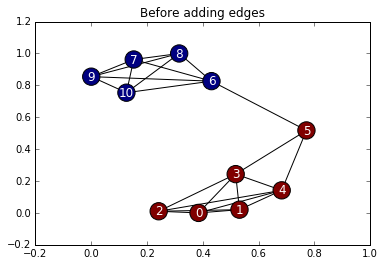

In [54]:
g = nx.barbell_graph(5, 1)
g.add_edge(3, 5)

_, part = metis.part_graph(g, 2)

nx.draw_networkx(g, font_color='white', node_color=part)
plt.title('Before adding edges')

3it [00:00, 3641.94it/s]

edge (5, 7)
moved node 5
8 stayed
3 stayed
4 stayed
6 stayed
7 stayed
edge (5, 8)
edge (0, 11)
moved node 11
0 stayed


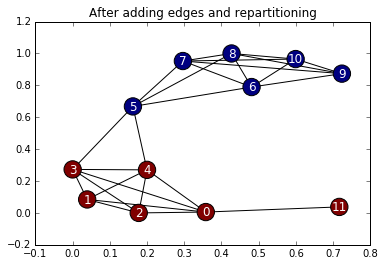

In [55]:
# part = update_partition(g, node_cluster_ids=part, edges_to_add=[(5, 7), (5, 8), (0, 11)])
node2cluster = dict(zip(g.nodes_iter(), part))
node2cluster = update_partition_new(g, node2cluster, edges_to_add=[(5, 7), (5, 8), (0, 11)])

nx.draw_networkx(g,
                 font_color='white',
                 node_color=[node2cluster[n] for n in g.nodes_iter()])
plt.title('After adding edges and repartitioning')

3it [00:00, 6037.87it/s]

edge (5, 7)
moved node 5
3 stayed
4 stayed
6 stayed
edge (5, 8)
edge (0, 11)
moved node 11


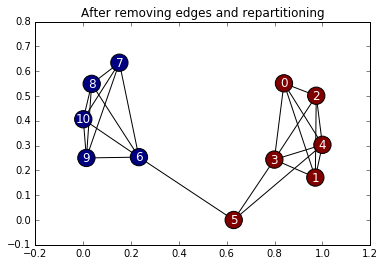

In [56]:
node2cluster = update_partition_new(g, node2cluster, edges_to_remove=[(5, 7), (5, 8), (0, 11)])
nx.draw_networkx(g,
                 font_color='white',
                 node_color=[node2cluster[n] for n in g.nodes_iter()])
plt.title('After removing edges and repartitioning')

In [57]:
def get_cut_ratio(g, cluster_node_ids):
    """support only 2 partitions currently                                                                                                                    
    """
    partition = defaultdict(set)
    for n, c in zip(g.nodes_iter(), cluster_node_ids):
        partition[c].add(n)
                                                                                                                                                              
    c1, c2 = list(partition.values())
    cuts = 0.0
    for u, v in g.edges_iter():
        if (u in c1 and v in c2) or (u in c2 and v in c1):
            cuts += 1
    return (cuts / g.number_of_edges(), c1, c2)

In [59]:
def performance(g, inc_node2cluster, raw_cuts, raw_cluster_ids):
    updated_cluster_ids = [inc_node2cluster[n] for n in g.nodes()]
    r1, c1, c2 = get_cut_ratio(g, updated_cluster_ids)
    size_1 = (len(c1), len(c2))
    
    r2 = raw_cuts / g.number_of_edges()     
    size_2 = tuple(Counter(raw_cluster_ids).values())
    return {'cut_ratio_1': r1, 
            'cut_ratio_2': r2,
            'size_1': size_1,
            'size_2': size_2}

In [60]:
cuts, raw_parts = metis.part_graph(g, 2)
performance(g, node2cluster, cuts, raw_parts)

{'cut_ratio_1': 0.043478260869565216,
 'cut_ratio_2': 0.043478260869565216,
 'size_1': (5, 6),
 'size_2': (5, 6)}

In [61]:
def sample_edges_to_add(g, n_edges_to_add,
                        unknown_nodes_pool=list(string.ascii_lowercase)):
    n = 0
    edges_to_add = []
    nodes = g.nodes()
    while n < n_edges_to_add:
        while True:
            u = v = random.choice(nodes)
                                                                                                                                                              
            if random.random() > 0.5:  # 0.5 proba to sample unknown nodes                                                                                    
                edges_to_add.append((u, random.choice(unknown_nodes_pool)))
                break
            else:  # 0.5 proba to sample existing edge                                                                                                        
                while u == v:
                    v = random.choice(nodes)
                if not g.has_edge(u, v):
                    edges_to_add.append((u, v))
                    break
        n += 1
    return edges_to_add

In [32]:
# test
assert len(sample_edges_to_add(g, 10)) == 10
for e in sample_edges_to_add(g, 10):
    assert not g.has_edge(*e)

In [63]:
# Experiment on real networks
from glob import glob
from time import time


add_edges_percent = 0.01
remove_edges_percent = 0.01

rows = []
datasets = ['circular', 'barbell', 'star', 'barabasi',
           'mtvhottest', 'beefban', 'baltimore', 'ukraine']
for name in tqdm(datasets):
    path = 'data/{}.gpkl'.format(name)
    print(name)
    g = nx.read_gpickle(path)
    _, parts = metis.part_graph(g, 2)
    node2cluster = dict(zip(g.nodes(), parts))
    edges_to_remove = random.sample(g.edges(), int(g.number_of_edges() * remove_edges_percent))
    edges_to_add = sample_edges_to_add(g, int(g.number_of_edges() * add_edges_percent))

    s = time()
    
    new_node2cluster = update_partition_new(g, 
                                     node2cluster,
                                     edges_to_add=edges_to_add,
                                     edges_to_remove=edges_to_remove,
                                     verbose=False)
    takes_time_1 = time() - s
    
    s = time()
    raw_cuts, raw_parts = metis.part_graph(g, 2)
    takes_time_2 = time() - s
    
    stat = performance(g, new_node2cluster, raw_cuts, raw_parts)
    stat['name'] = name
    stat['running_time_1'] = takes_time_1
    stat['running_time_2'] = takes_time_2
    stat['n_nodes'] = g.number_of_nodes()
    stat['n_edges'] = g.number_of_edges()
    rows.append(stat)

  0%|          | 0/8 [00:00<?, ?it/s]

circular


 12%|█▎        | 1/8 [00:01<00:12,  1.72s/it]

barbell


 25%|██▌       | 2/8 [00:15<00:32,  5.38s/it]

star


 38%|███▊      | 3/8 [00:21<00:27,  5.56s/it]

barabasi


 50%|█████     | 4/8 [00:24<00:19,  4.89s/it]

mtvhottest


 62%|██████▎   | 5/8 [00:28<00:13,  4.57s/it]

beefban


 75%|███████▌  | 6/8 [00:30<00:07,  3.66s/it]

baltimore


 88%|████████▊ | 7/8 [00:35<00:04,  4.20s/it]

ukraine


100%|██████████| 8/8 [00:38<00:00,  3.88s/it]


In [64]:
df = pd.DataFrame.from_records(rows)

In [66]:
g_stat = df[['name', 'n_nodes', 'n_edges']]
print(pd.DataFrame([g_stat['n_nodes'].as_matrix(), g_stat['n_edges'].as_matrix()], index=['#nodes', '#edges'], columns=g_stat['name'].as_matrix()).to_latex())

\begin{tabular}{lrrrrrrrr}
\toprule
{} &  circular &  barbell &   star &  barabasi &  mtvhottest &  beefban &  baltimore &  ukraine \\
\midrule
\#nodes &     50020 &     2026 &  49540 &     50026 &       63028 &    28047 &      93337 &    55914 \\
\#edges &     50000 &   998563 &  50000 &    149991 &      105826 &    47845 &     145300 &   105586 \\
\bottomrule
\end{tabular}



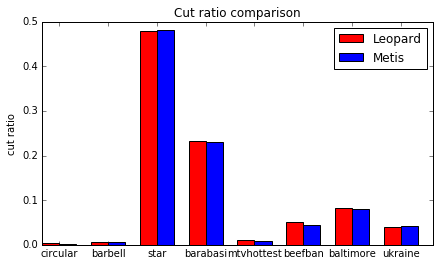

In [67]:
# cut ratio
fig, ax = plt.subplots()

N = df.shape[0]
ind = np.arange(N)
width = 0.35

ax.bar(ind, df['cut_ratio_1'], width, color='red')
ax.bar(ind+width, df['cut_ratio_2'], width, color='blue')

ax.set_xticks(ind + width)
ax.set_xticklabels(df['name'])
ax.set_ylabel('cut ratio')
ax.set_title('Cut ratio comparison')
fig.set_figwidth(7)
ax.legend(['Leopard', 'Metis'])
fig.savefig('figs/clustering_cut_ratio_comparison.pdf')

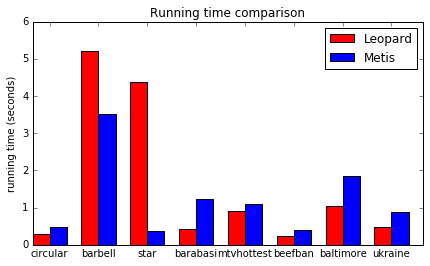

In [68]:
# cut ratio
fig, ax = plt.subplots()

N = df.shape[0]
ind = np.arange(N)
width = 0.35

ax.bar(ind, df['running_time_1'], width, color='red')
ax.bar(ind+width, df['running_time_2'], width, color='blue')

ax.set_xticks(ind + width)
ax.set_xticklabels(df['name'])
ax.set_ylabel('running time (seconds)')
ax.set_title('Running time comparison')
fig.set_figwidth(7)
ax.legend(['Leopard', 'Metis'])
fig.savefig('figs/clustering_running_time_comparison.pdf')